In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from __future__ import print_function
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import argparse
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm

### The below code is refereced from http://pytorch.org/docs/0.3.1/notes/cuda.html?highlight=argparse#memory-management


In [3]:
parser = argparse.ArgumentParser(description='PyTorch Example')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--interval',metavar='N',default=1000)
args = parser.parse_args(args=[])
args.cuda = not args.disable_cuda and torch.cuda.is_available()
#Is cuda is present?
print(args.cuda)
#Total number of GPU available
print(torch.cuda.device_count())


True
1


In [4]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('/opt/e533/MNIST',
                      train=True,
                      download=False,
                      transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
      datasets.MNIST('/opt/e533/MNIST',
                      train=False,
                      transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=128, shuffle=True)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))


==>>> total trainning batch number: 469


### The architecture of the model used is referred from http://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-1-convnet 

The architecture of the Deep Neural Network is as follows,

Linear(28*28,1024) ---> relu ---> [Linear(1024,1024)--->relu] *4 --> Linear(1024,10) --> softmax 

I have used negative log likelihood as loss function for this problem, and Adam optimization of learning rate 0.001 and default beta's values (0.9,0.999)


In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 10)
        
    def forward(self,x):
        x=F.relu(self.fc1(x))

        first_hid = x
        x=F.relu(self.fc2(x))

        second_hid = x
        x=F.relu(self.fc3(x))

        third_hid =x
        x=F.relu(self.fc4(x))

        fourth_hid = x
        x=F.relu(self.fc5(x))
        fifth_hid = x
        x=self.fc6(x)
        
        
        return [F.log_softmax(x,dim=1),first_hid,second_hid,third_hid,fourth_hid,fifth_hid]  

In [6]:
#Initialize the Custom Network
model=Net()
if args.cuda:
    model.cuda()

In [7]:
#OPtimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [8]:
#Define a loss function (Negative log likelihood)
criterion = nn.NLLLoss()

In [9]:
def train(epoch):
    for batch_idx,(data,target) in enumerate(train_loader):
        data=data.view(-1,28*28)
        if torch.cuda.is_available():
            data,target = data.cuda(),target.cuda()
        data,target = Variable(data),Variable(target)
        # Clears the gradients of all optimized Variables
        optimizer.zero_grad()
        y_pred = model(data)[0]
        
        loss = criterion(y_pred, target)        
        loss.backward()
        optimizer.step()
        if batch_idx % args.interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.data[0]))

In [10]:
for t in range(50):
    train(t) 

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303064
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.094452
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.058007
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.071516
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.039109
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011251
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.005314
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.043129
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.004060
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.025164
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.022714
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.007398
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.004060
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.028280
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.000608
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.000164
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.005168
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.001371
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.000229
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.000191
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.022053
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.02135

### The below code is referenced from http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-an-image-classifier

In [11]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    count =0
    
    for i,(data,target) in enumerate(test_loader):
        data = data.view(-1,28*28)
        
        if torch.cuda.is_available():
            data,target = data.cuda(),target.cuda()
        data,target = Variable(data),Variable(target)
        y_pred = model(data)[0]
        
        
        test_loss += criterion(y_pred, target).data[0]
        pred = y_pred.data.max(1)[1]
        correct += pred.eq(target.data).sum()
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.001f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * float(correct) / len(test_loader.dataset)))

In [12]:
#part 1.1
test()


Test set: Average loss: 0.0008, Accuracy: 9855/10000 (98.5%)



In [13]:
import numpy as np
def get_test_1000():
    test_data = np.empty((0,28*28))
    test_target = np.empty((0,1))
   
    for i_batch,sample_batched in enumerate(test_loader):
        test_target = np.append(test_target,sample_batched[1].numpy())
        test_data = np.append(test_data,sample_batched[0].view(-1,28*28).numpy(),axis=0)
        
        if test_data.shape[0] > 1000:
            break
    #Get first thousand test samples 
    test_data=test_data[:1000,:]
    test_target = test_target[:1000]
    
    #Converting back to tesnsors
    data = torch.from_numpy(test_data)
    target = torch.from_numpy(test_target)
    data,target = data.type(torch.FloatTensor),target.type(torch.LongTensor)
    return data,target

In [14]:
def predict_1000(data,target):
    model.eval()
    if torch.cuda.is_available():
            data,target = data.cuda(),target.cuda()
    data,target = Variable(data),Variable(target)
    all_op = model(data)
    return all_op

In [15]:
#part 1.3
def visualize_prediction(y_pred):
    
    print(y_pred.shape)
    all_index =np.empty((0,10))
    for i in range(y_pred.shape[1]):
        values, indices = torch.topk(y_pred[:,i], 10)
        if torch.is_tensor(indices):
            idx = indices.cpu().view(1,10).numpy()
        else:
            idx = indices.cpu().data.view(1,10).numpy()
        all_index = np.append(all_index,idx,axis=0)
    all_index = all_index.astype(int)

    list_index = [all_index[i,j] for i in range(10) for j in range(10)]
    
    images = [data[i,:].view(28,28) for i in list_index]
    
    fig, axes1 = plt.subplots(10,10,figsize=(5,5))
    for j in range(10):
        for k in range(10):
            id = int(str(k)+str(j))
            
            axes1[k][j].set_axis_off()
            axes1[k][j].imshow(images[id])
    plt.show()

torch.Size([1000, 10])


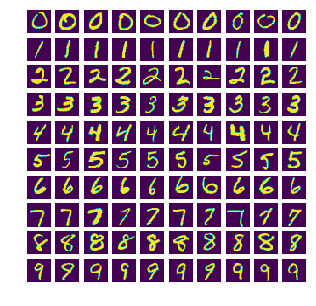

In [16]:
# Part 1.2
data,target = get_test_1000()
all_op = predict_1000(data,target)
visualize_prediction(all_op[0])

We are getting a perfect classification of all digit from the the softmax layer.

In [17]:
def get_random_10(ip):
    
    np_idx = np.random.randint(1024, size=10)
    np_idx = torch.LongTensor(torch.from_numpy(np_idx))
    if torch.cuda.is_available():
        np_idx= np_idx.cuda()
    
    new_ip = torch.index_select(ip.data, 1,np_idx)
    return new_ip

torch.Size([1000, 10])


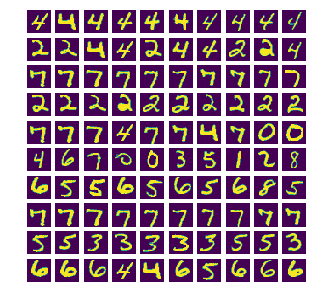

In [18]:
#Part 1.3
data,target = get_test_1000()
all_op = predict_1000(data,target)
#second last layer output
last_hid_10 = get_random_10(all_op[5])
visualize_prediction(last_hid_10)

We have tried to take random 10 vector from the last hidden layer output and from the plot we can see that, digit 4, digit 2 and digit 6 being activated and classified for other digits. But digit 7 is being accurately recognized. 

#### Raw 1000 test sample

##### TSNE and PCA aplied on the 1000 raw image test sample, to check it can be classified or not

In [19]:
def scatter_plot(data,target):
   
    data = np.array([data[:,0],data[:,1],target])
    data[2,:] = data[2,:].astype(int)
    
    mean_a = np.mean(data[(0), np.ix_(data[2,:] == 1)])
    
    group = np.unique(target)
    marker_size=15
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    
    for i in group:
        ax.scatter(data[0,:], data[1,:],marker_size,cmap=cm.jet,c = data[2,:])
        mean_x = np.mean(data[(0), np.ix_(data[2,:] == i)])
        mean_y =np.mean(data[(1), np.ix_(data[2,:] == i)])
        ax.annotate(str(i), xy=(mean_x,mean_y),size=30)
    plt.show()

In [20]:
#tsne
def apply_tsne(data):
    
    tsne = TSNE(n_components=2,init="pca",verbose=1, perplexity=40,early_exaggeration=40.0,learning_rate=150,n_iter=700)

    t0 =time()
    data_tsne = tsne.fit_transform(data)
    
    return data_tsne

In [21]:
#implementing PCA on the 1000 test sample
def apply_pca(data):
    pca = PCA(n_components=2,whiten=True,svd_solver="full")
    data_pca = pca.fit_transform(data)
    print(data_pca.shape)
    return data_pca

In [22]:
#PART 1.5 and 1.6
data,target = get_test_1000()
#Convert the data to numpy array for applying TSNE
data_np,target_np = data.numpy(),target.numpy()

data_reduced_tsne = apply_tsne(data_np)

data_reduced_pca = apply_pca(data_np)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.018s...
[t-SNE] Computed neighbors for 1000 samples in 1.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.470910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 301.321808
[t-SNE] Error after 700 iterations: 1.148268
(1000, 2)


### Test data after reducing with TSNE()

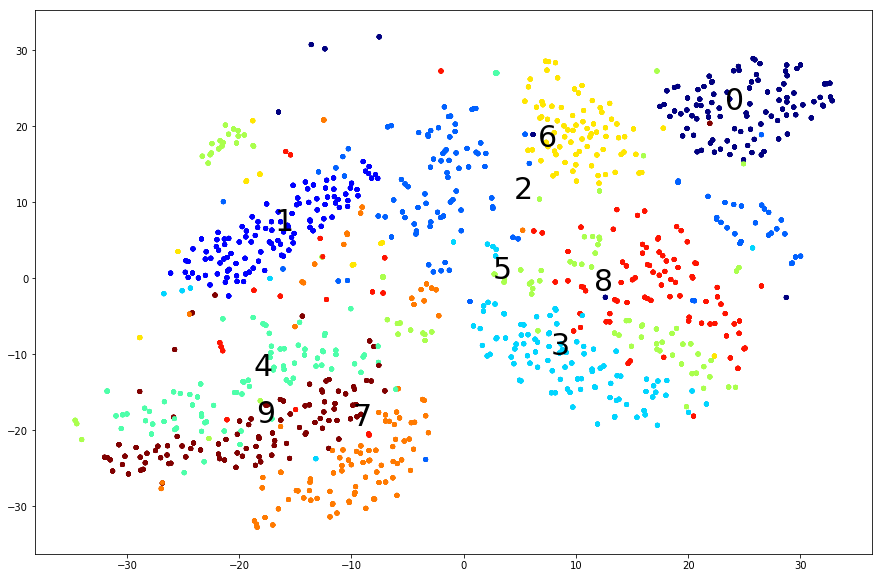

In [23]:
scatter_plot(data_reduced_tsne,target_np)

We can see from the above plot that, the reduced test data from TSNE are non-linearly seperable, we have to define a model to separate the classes.

### Test data after reducing with PCA()

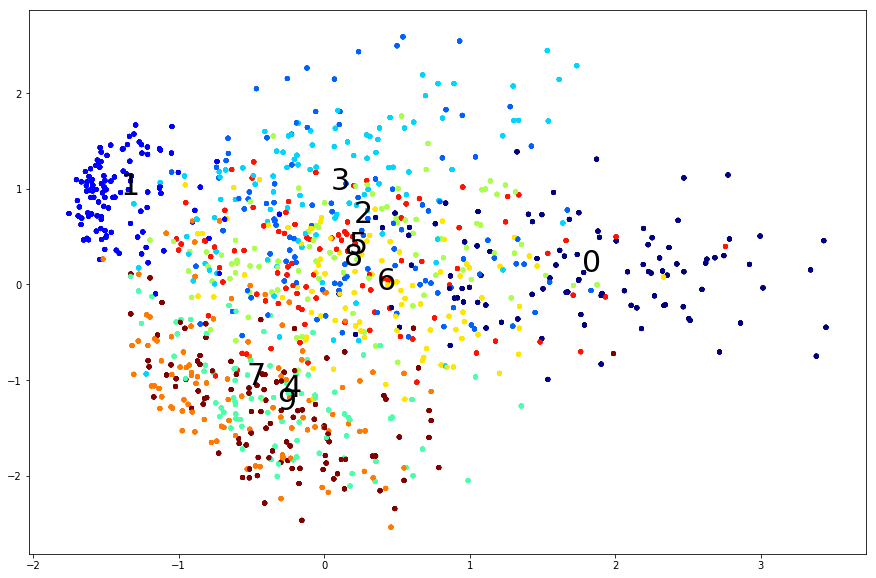

In [24]:
scatter_plot(data_reduced_pca,target_np)

From the above plots we can see that raw image cannot be classified even after reducing dimensionallity by applying TSNE and PCA

### Applying TSNE and PCA on output of feedforward of all layer, for 1000 test sample

#### 1000 test sample are fed into feedforward net
#### Output from each layers are captured 
#### TSNE and PCA are applied on the output to get 1000*2 size output vector

In [25]:
data,target = get_test_1000()
all_op = predict_1000(data,target)
#second last layer output
first_hid_np,second_hid_np,third_hid_np,fourth_hid_np,fifth_hid_np,last_lyr_np =all_op[1].data.cpu().numpy(),all_op[2].data.cpu().numpy(),all_op[3].data.cpu().numpy(),all_op[4].data.cpu().numpy(),all_op[5].data.cpu().numpy(),all_op[0].data.cpu().numpy()


target_np  = target.numpy()


first_hid_reduced_tsne = apply_tsne(first_hid_np)
first_hid_reduced_pca = apply_pca(first_hid_np)

second_hid_reduced_tsne = apply_tsne(second_hid_np)
second_hid_reduced_pca = apply_pca(second_hid_np)

third_hid_reduced_tsne = apply_tsne(third_hid_np)
third_hid_reduced_pca = apply_pca(third_hid_np)

fourth_hid_reduced_tsne = apply_tsne(fourth_hid_np)
fourth_hid_reduced_pca = apply_pca(fourth_hid_np)

fifth_hid_reduced_tsne = apply_tsne(fifth_hid_np)
fifth_hid_reduced_pca = apply_pca(fifth_hid_np)

last_lyr_reduced_tsne = apply_tsne(last_lyr_np)
last_lyr_reduced_pca = apply_pca(last_lyr_np)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.033s...
[t-SNE] Computed neighbors for 1000 samples in 2.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.541952
[t-SNE] KL divergence after 250 iterations with early exaggeration: 305.115112
[t-SNE] Error after 700 iterations: 0.897247
(1000, 2)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.025s...
[t-SNE] Computed neighbors for 1000 samples in 2.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.082833
[t-SNE] KL divergence after 250 iterations with early exaggeration: 299.229980
[t-SNE] Error after 700 iterations: 0.503588
(1000, 2)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.024s...
[t-SNE] Computed neighbors for 1000 samples in 2.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.754452
[t-SNE] KL divergence

### Output of first hidden layer and reduced dimension with TSNE()

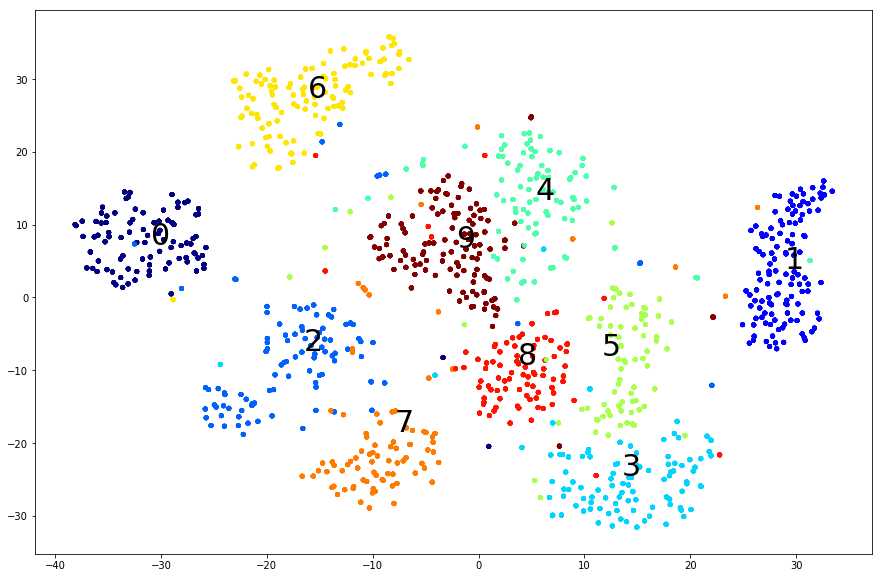

In [26]:
scatter_plot(first_hid_reduced_tsne,target_np)

From the output of first hidden layer,after applying TSNE we can see some of the classes like 6 and 1 seems to classified from the rest of the classes.

### Output of first hidden layer after applying PCA

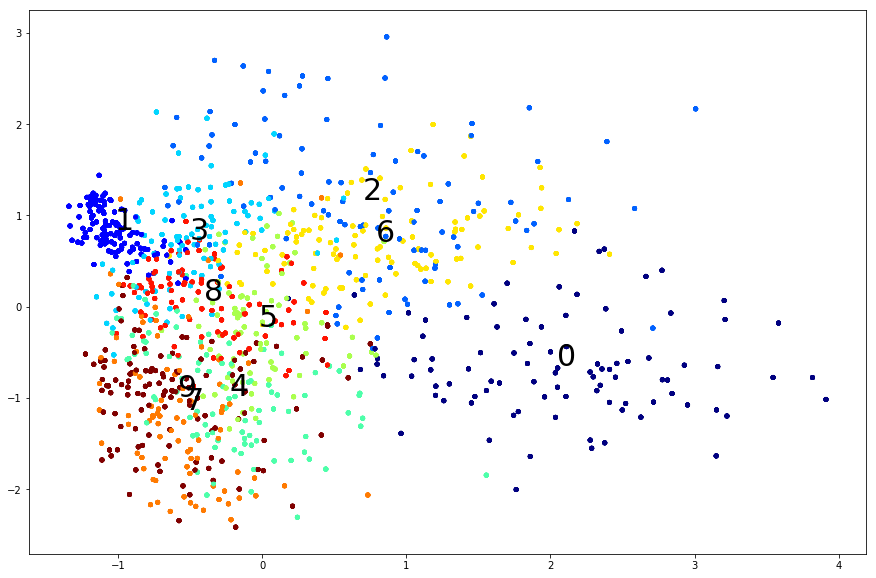

In [27]:
scatter_plot(first_hid_reduced_pca,target_np)

From the above plot we can see that the eigen vectors of all the classes are starting to get converged and class 0 seeems to be seperable

### Output of second hidden layer and reduced dimension with TSNE()

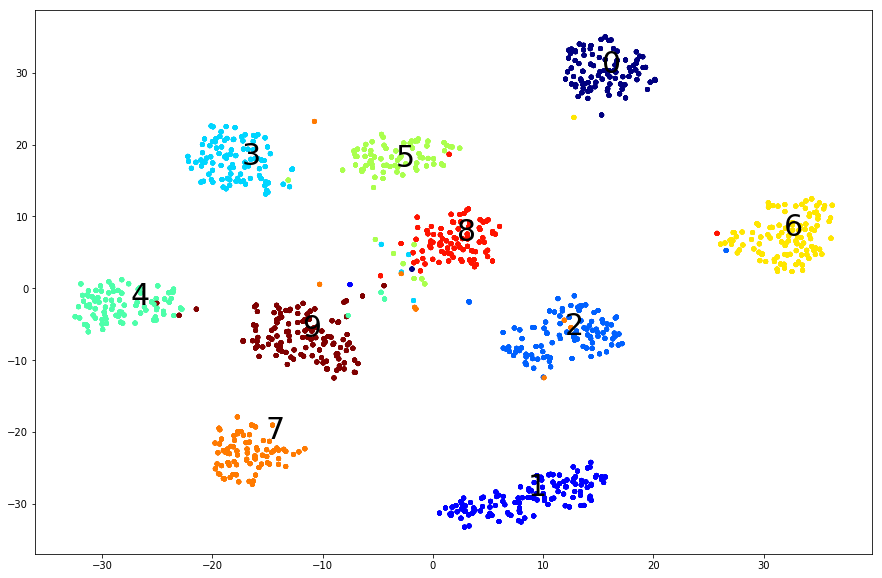

In [28]:
scatter_plot(second_hid_reduced_tsne,target_np)

The output of second hidden layer (reducing by TSNE) we can see that all the classess are getting to serable. But some of the classes have data of other class like Class 3 has som class 5 data.

### Output of second hidden layer after applying PCA

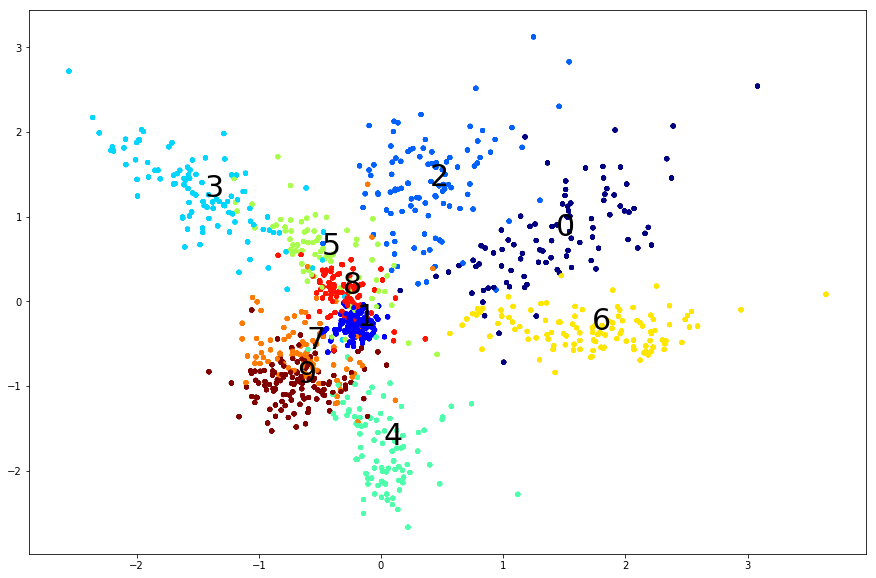

In [29]:
scatter_plot(second_hid_reduced_pca,target_np)

The results of PCA seems to be not easily seperable as TSNE

### Output of third hidden layer and reduced dimension with TSNE()

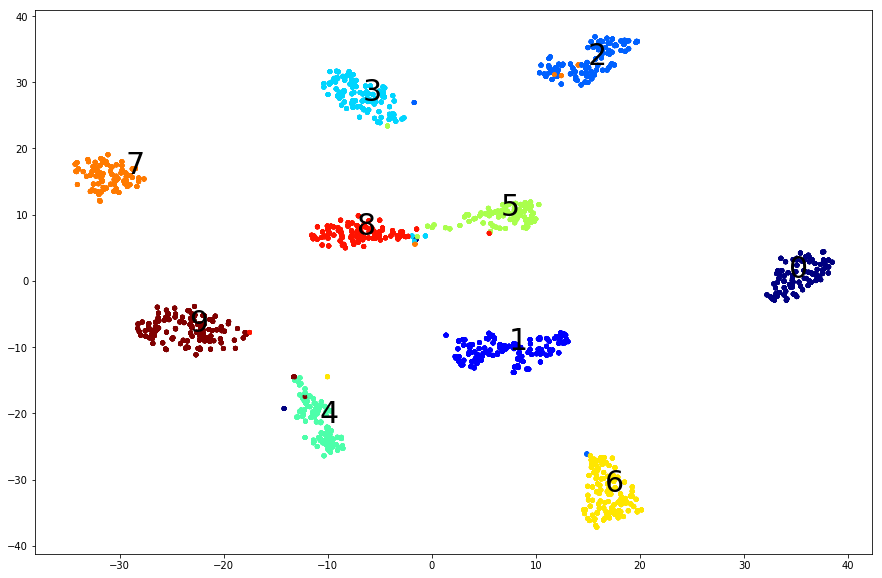

In [31]:
scatter_plot(third_hid_reduced_tsne,target_np)

The output of third hidden layer (reducing by TSNE) we can see that all the classess are getting to serable. still we have some of the classes having data of other class.

### Output of third hidden layer after applying PCA

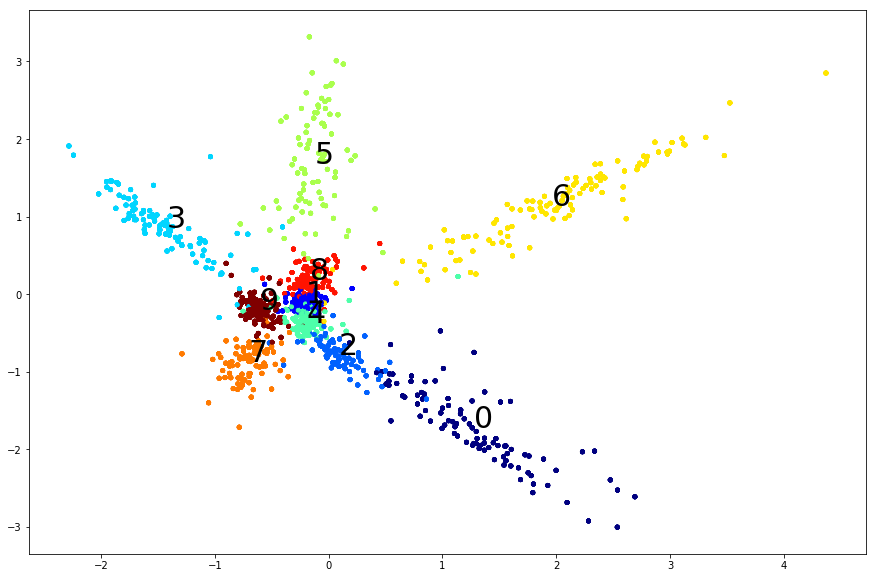

In [86]:
scatter_plot(third_hid_reduced_pca,target_np)

Classes like 6,5,3 and 0 are getting seperable for PCA on third layer

### Output of fourth hidden layer and reduced dimension with TSNE()

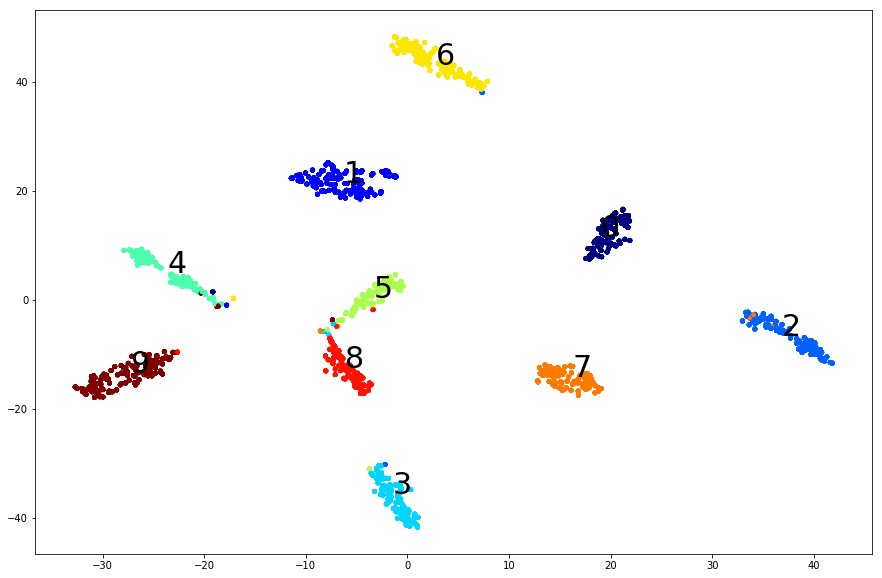

In [32]:
scatter_plot(fourth_hid_reduced_tsne,target_np)

The TSNE on third hidden layer output is gettin better in the sense of seperable of all classes

### Output of fourth hidden layer after applying PCA

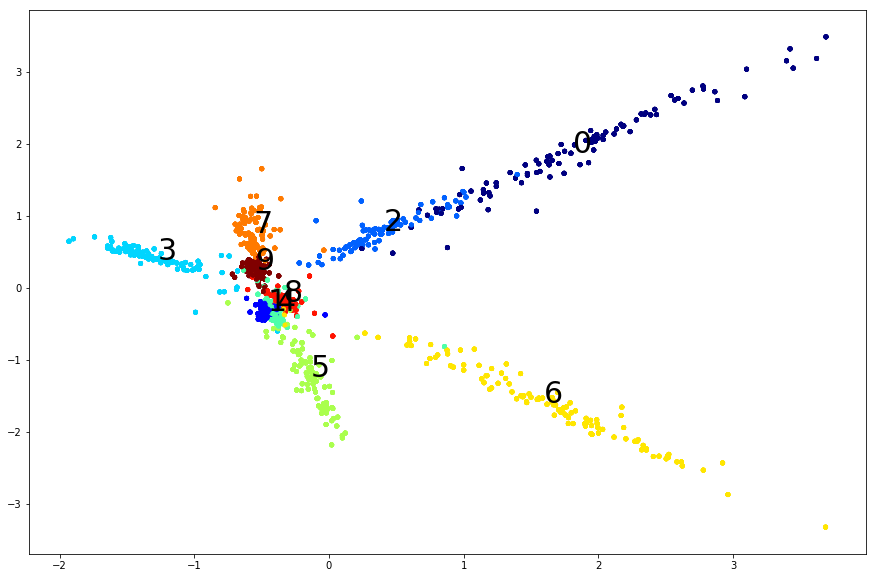

In [88]:
scatter_plot(fourth_hid_reduced_pca,target_np)

The PCA on third layer is getting worse, class 0 and class 2 are getting overlapped. and Class 6,5,3 seems to be seperable

### Output of fifth hidden layer and reduced dimension with TSNE()

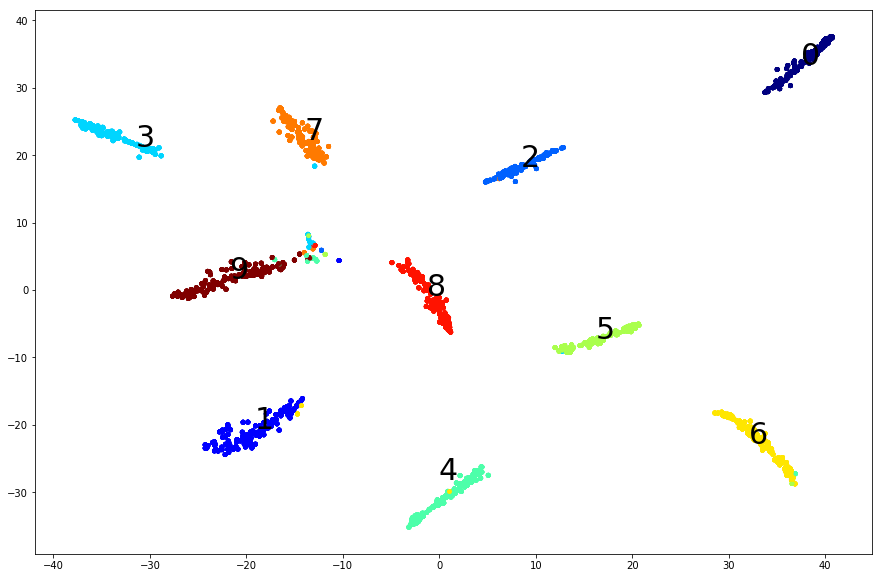

In [89]:
scatter_plot(fifth_hid_reduced_tsne,target_np)

TSNE on the fifth hidden layer is good, and the classes are easily seperable.

### Output of fifth hidden layer after applying PCA

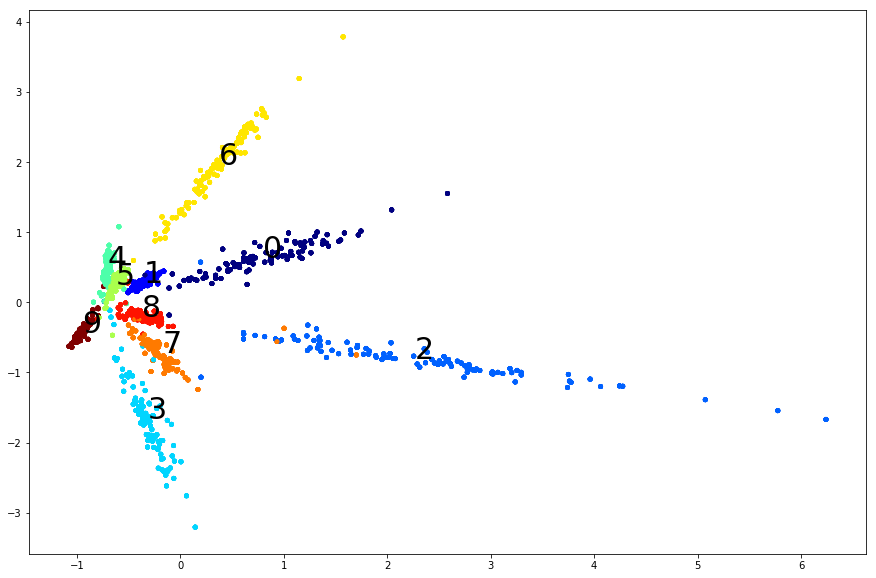

In [34]:
scatter_plot(fifth_hid_reduced_pca,target_np)

The PCA on fifth hidden layer output are getting good. The class 3,2,6,0and 7 are getting seperable 

### Output of last layer and reduced dimension with TSNE()

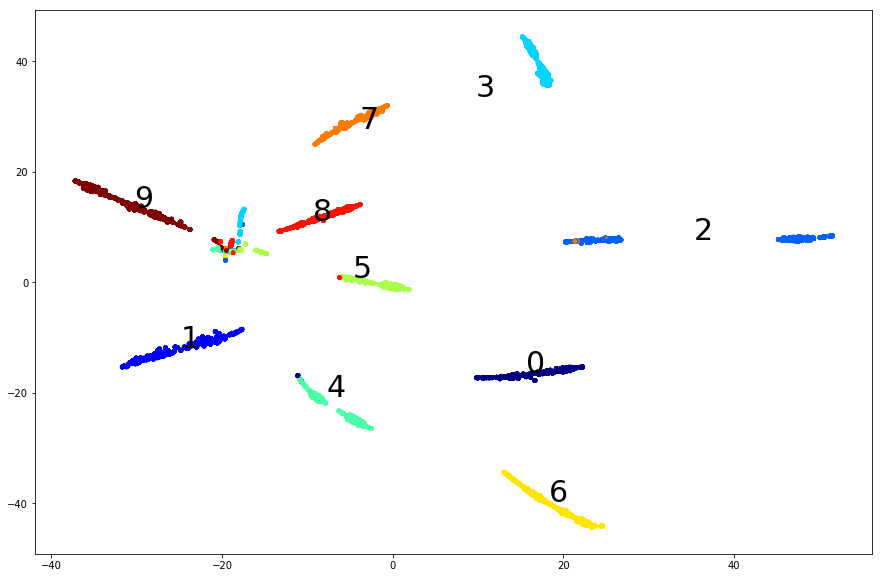

In [36]:
scatter_plot(last_lyr_reduced_tsne,target_np)

TSNE on the last layer is good, and almost most of the data are getting seperable. There are some data that could not be seperable, I think these are test error

### Output of last layer after applying PCA

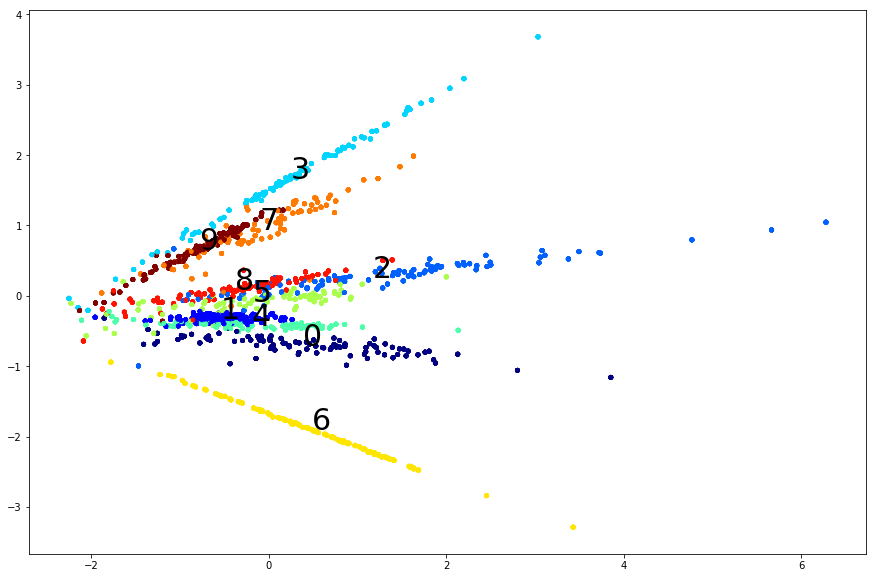

In [37]:
scatter_plot(last_lyr_reduced_pca,target_np)

The PCA on last layer output seems to be non linearly seperable for some of the classes.